# Desafio Titanic
---


- Previsão de sobreviventes dos passageiros.
- Base de dados: Desafio do Kaggle.

## Bibliotecas e importação das bases de dados

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn import metrics
#from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Tratamento dos dados

In [5]:
df = pd.DataFrame()

- Juntando DataFrames de test e train

In [6]:
passengerId = test['PassengerId']
titanic_df = pd.merge(train, test, how='outer')

In [7]:
train_index = len(train)
test_index = len(titanic_df) - len(test)

### Sexo
- Tratando coluna sexo para dados numéricos (feminino = 1 /// masculino = 0)

In [8]:
titanic_df['Sex'] = titanic_df['Sex'].map({'female': 1, 'male': 0})
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,8.0500,NaN,S


### Idade

In [9]:
# Tratamento de valores faltantes.
    # Iremos pegar a média de idade para cada classe. Pois pegar a média de idade geral pode ter viés.

In [10]:
mediaAge1pclass = round(titanic_df[titanic_df['Pclass'] == 1]['Age'].mean())
mediaAge2pclass = round(titanic_df[titanic_df['Pclass'] == 2]['Age'].mean())
mediaAge3pclass = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean())

print(f'Média de idade da 1° Classe {mediaAge1pclass:.2f} anos')
print(f'Média de idade da 2° Classe {mediaAge2pclass:.2f} anos')
print(f'Média de idade da 3° Classe {mediaAge3pclass:.2f} anos')

Média de idade da 1° Classe 39.00 anos
Média de idade da 2° Classe 30.00 anos
Média de idade da 3° Classe 25.00 anos


In [11]:
titanic_df['Age'].isnull().sum()

263

In [12]:
# Função para preencher valores faltantes na coluna 'Age' com a média correspondente à classe
def preencher_idade(row):
    if pd.isnull(row['Age']):
        if row['Pclass'] == 1:
            return mediaAge1pclass
        elif row['Pclass'] == 2:
            return mediaAge2pclass
        elif row['Pclass'] == 3:
            return mediaAge3pclass
    else:
        return row['Age']

# Aplica a função para preencher os valores faltantes na coluna 'Age'
titanic_df['Age'] = titanic_df.apply(preencher_idade, axis=1)

In [13]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,25.0,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",0,25.0,0,0,359309,8.0500,NaN,S


In [14]:
df['Survived'] = titanic_df['Survived']
df['Pclass'] = titanic_df['Pclass']
df['Sex'] = titanic_df['Sex']
df['Age'] = titanic_df['Age']
#df['SibSp'] = titanic_df['SibSp']
#df['Parch'] = titanic_df['Parch']

### FamilySize
- Criamos essa coluna apartir das informações das colunas SibSp e Parch.

In [15]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

In [16]:
df['FamilySize'] = titanic_df['FamilySize']

### Fare

In [17]:
titanic_df['Fare'].fillna(13, inplace=True) # Com análise, vimos que a média de valor pago apra passageiros da terceira classe foi de 13 dólares
df['Fare'] = titanic_df['Fare']

### Cabin

- maioria dos dados dessa coluna são nulos, estão iremos retira-los.
- Depois, tentar tratar esses dados para treinar o modelo com essas informações. Pois isso pode dizer a posição das pessoas dentro do navio e informar se estavam perto ou não dos botes salva-vidas

In [18]:
titanic_df['Cabin'].isnull().sum()

1014

### Embarked

In [19]:
titanic_df['Embarked'].isnull().sum()

2

In [20]:
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
61,62,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN,1


In [21]:
titanic_df['Embarked'].fillna("C", inplace=True) #Atribuí que entraram pelo portão C, pois no portão C foi por onde entraram a maior parte das pessoas de 1° classe

In [22]:
df['Embarked'] = titanic_df['Embarked']

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Sex         1309 non-null   int64  
 3   Age         1309 non-null   float64
 4   FamilySize  1309 non-null   int64  
 5   Fare        1309 non-null   float64
 6   Embarked    1309 non-null   object 
dtypes: float64(3), int64(3), object(1)
memory usage: 71.7+ KB


### Cabin

In [24]:
titanic_df['Cabin'].value_counts()

Cabin
C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: count, Length: 186, dtype: int64

In [25]:
# Extraindo a primeira letra da coluna "Cabin"
titanic_df['Cabin'] = titanic_df['Cabin'].str[0]

<Axes: >

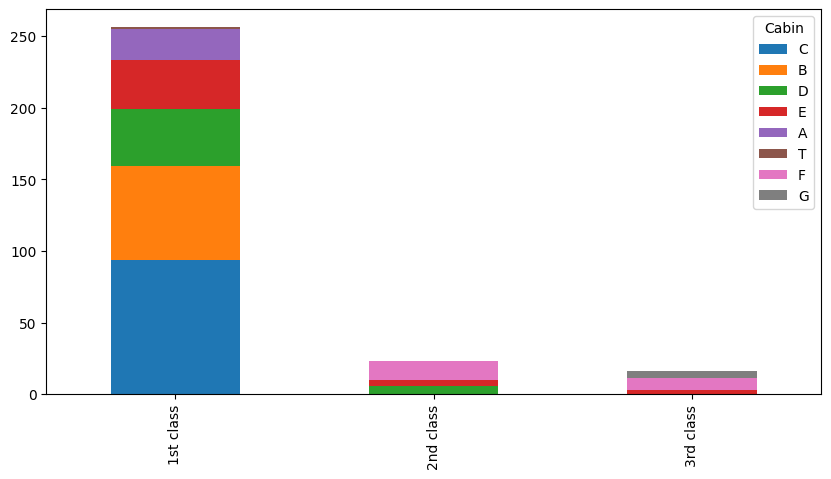

In [26]:
Pclass1 = titanic_df[titanic_df['Pclass']==1]['Cabin'].value_counts()
Pclass2 = titanic_df[titanic_df['Pclass']==2]['Cabin'].value_counts()
Pclass3 = titanic_df[titanic_df['Pclass']==3]['Cabin'].value_counts()
teste = pd.DataFrame([Pclass1, Pclass2, Pclass3])
teste.index = ['1st class','2nd class', '3rd class']
teste.plot(kind='bar',stacked=True, figsize=(10,5))

In [27]:
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}

# Aplicando o mapeamento diretamente sem loop
titanic_df['Cabin'] = titanic_df['Cabin'].replace(cabin_mapping)

# Exibindo os DataFrames resultantes
titanic_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0.8,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0.8,S,2
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1


In [28]:
#Agora iremos filtrar os dados que estão nulos
titanic_df['Cabin'].fillna(titanic_df.groupby("Pclass")["Cabin"].transform("median"), inplace = True)
titanic_df['Cabin'] = titanic_df['Cabin'].astype(int)

In [29]:
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0,C,2


In [30]:
df['Cabin'] = titanic_df['Cabin']
df.head(2)

,Survived,Pclass,Sex,Age,FamilySize,Fare,Embarked,Cabin
0,0.0,3,0,22.0,2,7.2500,S,2
1,1.0,1,1,38.0,2,71.2833,C,0


## Inicio modelagem Machine Learning

##### Criando variáveis dummies

In [31]:
pclass = pd.get_dummies(df['Pclass'], prefix='pclass').astype(int)
embarked = pd.get_dummies(df['Embarked'], prefix='embarked').astype(int)
#cabin = pd.get_dummies(df['Cabin'], prefix='cabin').astype(int)

In [32]:
titanic_dummies = pd.concat([df, pclass, embarked], axis=1)
titanic_dummies.drop(['Pclass', 'Embarked'] ,axis = 1, inplace = True)

In [33]:
titanic_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Sex         1309 non-null   int64  
 2   Age         1309 non-null   float64
 3   FamilySize  1309 non-null   int64  
 4   Fare        1309 non-null   float64
 5   Cabin       1309 non-null   int32  
 6   pclass_1    1309 non-null   int32  
 7   pclass_2    1309 non-null   int32  
 8   pclass_3    1309 non-null   int32  
 9   embarked_C  1309 non-null   int32  
 10  embarked_Q  1309 non-null   int32  
 11  embarked_S  1309 non-null   int32  
dtypes: float64(3), int32(7), int64(2)
memory usage: 87.1 KB


##### Divisão em Treino e Teste

In [34]:
train = titanic_dummies[:train_index]
test = titanic_dummies[test_index:]

In [35]:
train['Survived'] = train['Survived'].astype(int)

C:\Users\joaov\AppData\Local\Temp\ipykernel_33648\1688987174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Survived'] = train['Survived'].astype(int)


In [36]:
X = train.drop('Survived', axis=1)
y = train['Survived']

In [37]:
X_test = test.drop('Survived', axis=1)


##### Criação dos modelos

In [38]:
def func_acuracia(algoritmo, X_train, y_train, vc):
    modelo = algoritmo.fit(X_train, y_train)
    acuracia = round(modelo.score(X_train, y_train) * 100, 2)
    
    train_pred = model_selection.cross_val_predict(algoritmo, X_train, y_train, cv = vc, n_jobs = -1)
    acuracia_vc = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return acuracia, acuracia_vc

##### Criando com Random Forest

In [39]:
acc_rf, acc_vc_rf = func_acuracia(RandomForestClassifier(), X, y,10)

print(f"Acuracia: {acc_rf}")
print(f"Acuracia: {acc_vc_rf}")

Acuracia: 98.2
Acuracia: 80.92


##### Criando com Logistic Regressor

In [40]:
acc_log, acc_vc_log = func_acuracia(LogisticRegression(max_iter=1000), X, y,10)

print(f"Acuracia: {acc_log}")
print(f"Acuracia: {acc_vc_log}")

Acuracia: 80.92
Acuracia: 80.36


Criando com Extra Trees

In [41]:
acc_et, acc_vc_et = func_acuracia(ExtraTreesClassifier(), X, y,10)

print(f"Acuracia: {acc_et}")
print(f"Acuracia: {acc_vc_et}")

Acuracia: 98.2
Acuracia: 80.25


##### Criando com XgBoost

In [42]:
acc_xgb, acc_vc_xgb = func_acuracia(XGBClassifier(), X, y, 10)

print(f"Acuracia: {acc_xgb}")
print(f"Acuracia: {acc_vc_xgb}")

Acuracia: 96.97
Acuracia: 82.04


##### Criando com Gradient Boost Classifier

In [43]:
acc_gbt, acc_vc_gbt = func_acuracia(GradientBoostingClassifier(), X, y, 10)

print(f"Acuracia: {acc_gbt}")
print(f"Acuracia vc: {acc_vc_gbt}")

Acuracia: 89.67
Acuracia vc: 82.72


### Modelo Escolhido
- Com base nos testes, o modelo que melhor performou foi o *Gradient Boost Classifier*, com acuracia de 83.05

### Tunagem do modelo (hiperparametros)

In [44]:
# Definir os parâmetros a serem tunados
param_grid = {
    'n_estimators': [10, 20, 40,100],
    #'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    #'loss': ['deviance', 'exponential'],
    'subsample': [0.7, 0.8, 0.9],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
}



In [45]:
# Criar o objeto GridSearchCV
gbt_clf = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=param_grid,
    cv=10,
    verbose=1,
    scoring='accuracy',
)

# Treinar o modelo
gbt_clf.fit(X, y)

# Imprimir os melhores parâmetros
print(gbt_clf.best_params_)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 40, 'subsample': 0.8}


In [46]:
print(f"A melhor pontuação foi: {gbt_clf.best_score_}")

A melhor pontuação foi: 0.8451810237203496


In [47]:
gradientBoosting_pred = gbt_clf.predict(X_test)

In [48]:
kaggle = pd.DataFrame({'passengerId' : passengerId, 'Survived': gradientBoosting_pred})
kaggle.to_csv('Titanic_gradient_boost_pred.csv', index=False)

In [49]:
kaggle

,passengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Resultados
- Primeiro teste: com todas as colunas originais: 0.8429
- Segundo teste: Retirando as colunas Sib e Parch: 0.8485
 - Segundo teste: Retirando as colunas: 0.8451